### Import necessary libraries

In [ ]:
!pip install pyLDAvis
!pip install nltk

     |████████████████████████████████| 1.6MB 2.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=b1e3fe58ef7d1ebb8c2c9aba42f09452deb0edf6bc7960fcad1e9b14ddda9342
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
#Import libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)

from IPython.display import display, HTML
display(HTML(data="""
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 95%; }
   div#maintoolbar-container { width: 99%; }
</style>
"""))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Upload the database file exported as csv



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AMERICA.csv to AMERICA.csv


### Data ingestion and cleaning

In [ ]:
#Read data
raw_data = pd.read_csv("AMERICA.csv")
raw_data.shape

(350, 7)

### How does the data look ?

In [ ]:
raw_data.head()

,CONTINENT,COUNTRY,HOTEL,REVIEW DATE,FEEDBACK,REVIEW,STAY DATE
0,NORTH AMERICA,USA,AQUALINA RESORT,18-10-2020,Best staycation,Had such a nice staycation at Acqualina! Loved...,October 2020
1,NORTH AMERICA,USA,AQUALINA RESORT,11-10-2020,EXCELLENT,I had the pleasure to visit Miamias best kept ...,October 2020
2,NORTH AMERICA,USA,AQUALINA RESORT,05-10-2020,Honeymoon During COVID,Amazing! Had lots of gluten free options! Staf...,September 2020
3,NORTH AMERICA,USA,AQUALINA RESORT,01-09-2020,First time...but hopefully not the last,"If you're going to Acqualina, prepare to be wo...",September 2020
4,NORTH AMERICA,USA,AQUALINA RESORT,01-09-2020,COVID Safety was paramount,Frequent visitor---as an older dentist Covid p...,August 2020


In [ ]:
raw_data.tail()

,CONTINENT,COUNTRY,HOTEL,REVIEW DATE,FEEDBACK,REVIEW,STAY DATE
345,NORTH AMERICA,USA,WENTWORTH MANSION,01-02-2020,Lovely stay at Lovely Place,You better plan some extra time to really enjo...,January 2020
346,NORTH AMERICA,USA,WENTWORTH MANSION,01-02-2020,"Potential 5 Stars when music ""problem"" solved!l",My wife and I recently spent three nights here...,January 2020
347,NORTH AMERICA,USA,WENTWORTH MANSION,01-02-2020,Southern Charm & Excellence,"Our stay was a weekend of rest, relaxation, an...",February 2020
348,NORTH AMERICA,USA,WENTWORTH MANSION,01-01-2020,50th Wedding Anniversary Celebration,We recently celebrated our 50th Wedding Annive...,January 2020
349,NORTH AMERICA,USA,WENTWORTH MANSION,01-01-2020,like being a guest in a home,Our stay at the Wentworth Mansion had the feel...,January 2020


## NLP preprocessing data

In [ ]:
# NLTK Stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['com', 'response', 'request'])

# Convert to list
data = raw_data.REVIEW.values.tolist()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[3]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('also', 1),
  ('anticipate', 1),
  ('beach', 1),
  ('big', 1),
  ('chair', 1),
  ('come', 1),
  ('especially', 2),
  ('even', 1),
  ('friendly', 1),
  ('help', 1),
  ('love', 2),
  ('moment', 1),
  ('need', 1),
  ('pool', 2),
  ('see', 1),
  ('staff', 2),
  ('sweet', 1),
  ('think', 1),
  ('wait', 1)],
 [('beach', 1),
  ('big', 1),
  ('come', 1),
  ('love', 1),
  ('see', 1),
  ('staff', 3),
  ('sweet', 1),
  ('almost', 1),
  ('anywhere', 1),
  ('attentive', 1),
  ('award', 3),
  ('bar', 1),
  ('best', 2),
  ('breakfast', 1),
  ('buzz', 1),
  ('celebrity', 1),
  ('chance', 1),
  ('chaos', 1),
  ('create', 2),
  ('day', 4),
  ('defy', 1),
  ('delicious', 1),
  ('dine', 1),
  ('dining', 2),
  ('dinner', 2),
  ('distinct', 1),
  ('drink', 3),
  ('eat', 1),
  ('else', 1),
  ('evening', 1),
  ('excellent', 1),
  ('exceptional', 1),
  ('experience', 3),
  ('flavor', 1),
  ('foreign', 1),
  ('forget', 1),
  ('full', 1),
  ('get', 3),
  ('go', 1),
  ('good', 5),
  ('gorgeous', 1),
  ('hope',

In [ ]:
len(corpus)

350

## Run multiple LDA models with different *N* topics to find the best *N-topic model*


### Compute coherence score for mulitple 'N' number of topics to find the optimum number

In [ ]:
%%time
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [ ]:
%%time
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=3, limit=20, step=1)

CPU times: user 50.8 s, sys: 25.3 ms, total: 50.8 s
Wall time: 50.8 s


### Plot the coherence scores for different N topics
#### Select optimum N

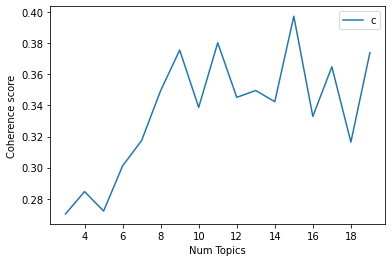

In [ ]:
## Plot the coherence scores for different N topics
### Select optimum N

# Show graph
limit=20; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.2702
Num Topics = 4  has Coherence Value of 0.2846
Num Topics = 5  has Coherence Value of 0.2721
Num Topics = 6  has Coherence Value of 0.3011
Num Topics = 7  has Coherence Value of 0.3174
Num Topics = 8  has Coherence Value of 0.3495
Num Topics = 9  has Coherence Value of 0.3755
Num Topics = 10  has Coherence Value of 0.3387
Num Topics = 11  has Coherence Value of 0.3802
Num Topics = 12  has Coherence Value of 0.3452
Num Topics = 13  has Coherence Value of 0.3496
Num Topics = 14  has Coherence Value of 0.3424
Num Topics = 15  has Coherence Value of 0.3973
Num Topics = 16  has Coherence Value of 0.3329
Num Topics = 17  has Coherence Value of 0.3648
Num Topics = 18  has Coherence Value of 0.3164
Num Topics = 19  has Coherence Value of 0.3739


In [ ]:
max_index = max(enumerate(coherence_values),key=lambda x: x[1])[0]

# Select the model and print the topics
#optimal_model = model_list[max_index]
optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))


[(0,
  '0.016*"wonderful" + 0.015*"thank" + 0.012*"service" + 0.012*"staff" + '
  '0.012*"take" + 0.012*"go" + 0.011*"perfect" + 0.011*"visit" + 0.010*"come" '
  '+ 0.010*"make" + 0.010*"resort" + 0.009*"family" + 0.009*"find" + '
  '0.008*"hospitality" + 0.008*"prior" + 0.007*"beautiful" + 0.007*"modern" + '
  '0.007*"item" + 0.007*"ever" + 0.007*"outstanding" + 0.006*"welcome" + '
  '0.006*"vacation" + 0.006*"else" + 0.006*"single" + 0.006*"time" + '
  '0.006*"photo" + 0.006*"continue" + 0.006*"even" + 0.006*"actually" + '
  '0.005*"deal"'),
 (1,
  '0.016*"hotel" + 0.013*"check" + 0.012*"would" + 0.012*"dog" + 0.011*"music" '
  '+ 0.011*"guest" + 0.010*"room" + 0.009*"bad" + 0.008*"service" + '
  '0.008*"coffee" + 0.008*"think" + 0.007*"never" + 0.007*"bathroom" + '
  '0.006*"include" + 0.006*"area" + 0.006*"morning" + 0.006*"detail" + '
  '0.006*"understand" + 0.006*"book" + 0.005*"large" + 0.005*"turn" + '
  '0.005*"change" + 0.005*"beverage" + 0.005*"man" + 0.005*"rest" + '
  '0.0

### Dominant topic in each document and topic weight

Each document (here, each data point) can be composed of multiple topics. But generally there one dominant topic, let's extract that.

In [ ]:
%%time
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


CPU times: user 1.96 s, sys: 1.97 ms, total: 1.96 s
Wall time: 1.97 s


### Most representative sentence for each topic

In [ ]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4512,"wonderful, thank, service, staff, take, go, pe...",Had such a nice staycation at Acqualina! Loved...
1,1,11.0,0.2426,"room, experience, staff, great, spa, property,...",I had the pleasure to visit Miamias best kept ...
2,2,11.0,0.3177,"room, experience, staff, great, spa, property,...",Amazing! Had lots of gluten free options! Staf...
3,3,4.0,0.3436,"stay, room, make, staff, great, time, service,...","If you're going to Acqualina, prepare to be wo..."
4,4,4.0,0.9653,"stay, room, make, staff, great, time, service,...",Frequent visitor---as an older dentist Covid p...
5,5,8.0,0.4129,"stay, room, hotel, breakfast, time, amazing, s...",From the beginning to the end everything was p...
6,6,4.0,0.9243,"stay, room, make, staff, great, time, service,...",Incredible hotel and fantastic service! Jimmy ...
7,7,11.0,0.3871,"room, experience, staff, great, spa, property,...",what an amazing resort. My wife and i came her...
8,8,4.0,0.6235,"stay, room, make, staff, great, time, service,...",From the moment you arrive you will understand...
9,9,4.0,0.5698,"stay, room, make, staff, great, time, service,...",I am one who does not take reviews lightly. I ...


In [ ]:
df_dominant_topic.to_csv('topics.csv')

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8495,"wonderful, thank, service, staff, take, go, perfect, visit, come, make",Our family trip was so perfect because of the wonderful accommodations and service provided. The...
1,1.0,0.6745,"hotel, check, would, dog, music, guest, room, bad, service, coffee",My wife and I recently spent three nights here. So much of what is written by other reviewers is...
2,2.0,0.4720,"hotel, note, write, high, champagne, tea, multiple, easily, onsite, quiet",The Broadmoor is one of the few Hotels still on my bucket list so it seemed like a great place t...
3,3.0,0.6998,"room, eat, pool, day, go, quiet, kid, get, nice, dinner",We came as just a couple without a kid. I think this resort is more enjoyable with a kid. We sta...
4,4.0,0.9834,"stay, room, make, staff, great, time, service, get, night, feel",We have been traveling to Acqualina for over 10 years now. It amazed us a decade ago and still a...
5,5.0,0.4936,"historic, due, exquisite, knowledge, plenty, reopen, treatment, grand, maintain, worry","We had an AMAZING experience on our Fins Course! Dillon was a funny, expert and competent leader..."
6,6.0,0.6588,"forward, handle, spoiled, wing, building, reason, discount, device, communication, broadmoor","Yes, the setting is stunning with its immediacy and intimacy reflected in the public spaces and ..."
7,7.0,0.8145,"dinner, luggage, professional, meet, elegant, cordial, unique, maintain, cancel, would",I attempted to book a room for a bridal party and soon to be husband and wife. After a lengthy d...
8,8.0,0.8918,"stay, room, hotel, breakfast, time, amazing, staff, service, mansion, good","Didnt expect to have such nice and amazing customer service experience , the staff are friendly,..."
9,9.0,0.3315,"cheese, measure, virus, oatmeal, thorough, bath, finger, necessary, appreciated, aside",Theyare using it for COVID-19 measures and itas ended up being a series of alcohol fueled loudne...


In [ ]:
sent_topics_sorteddf_mallet.to_csv('keywords.csv')

### Word cloud for Top words in Each topic

Each topic is represent as a word cloud made up of the keywords with the size of the word in the plot, proportional to its weightage.

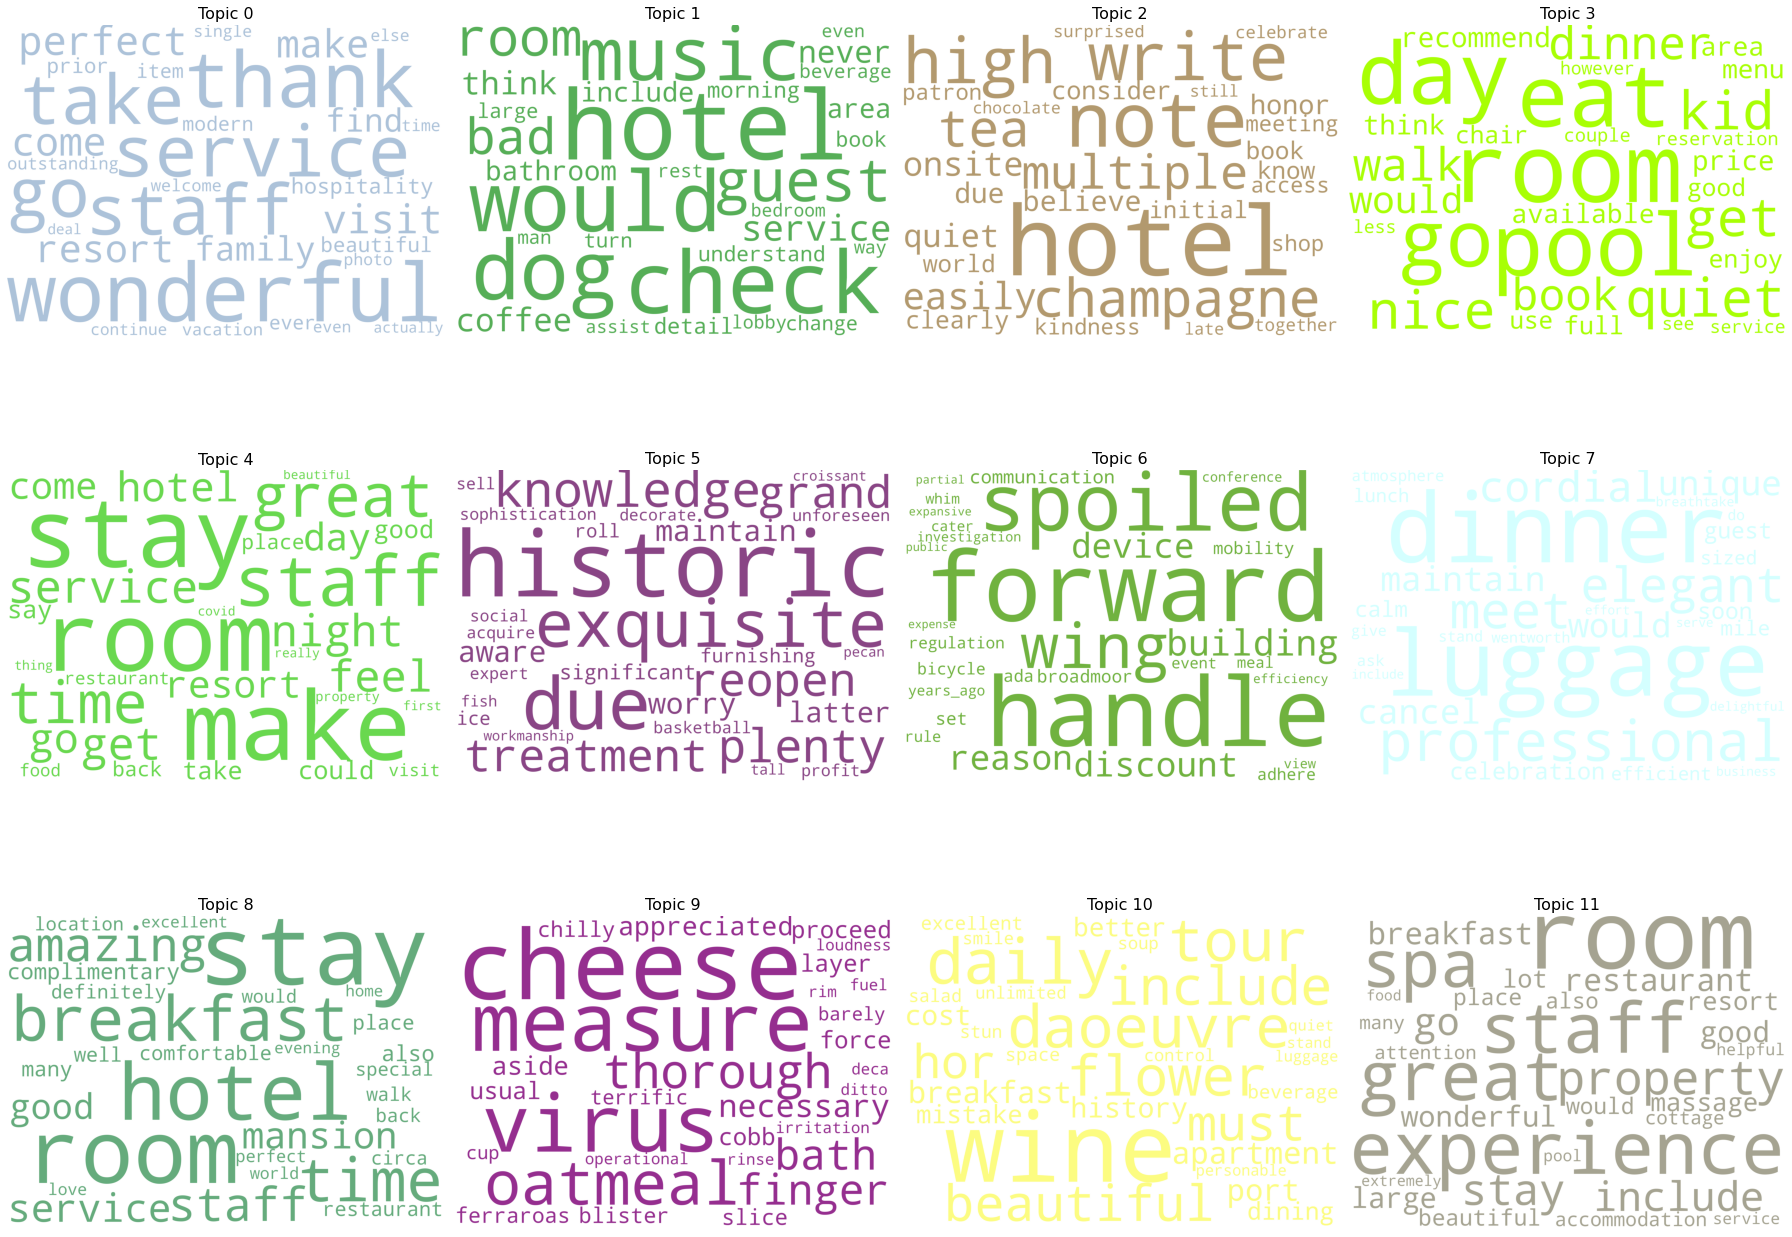

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'


cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='paired',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=30, num_words=30)
topics.sort(key=lambda tup: tup[0])

fig, axes = plt.subplots(3, 4, figsize=(25,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=550)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
topics

[(0,
  [('wonderful', 0.016203735),
   ('thank', 0.014761104),
   ('service', 0.012431749),
   ('staff', 0.011899933),
   ('take', 0.011594736),
   ('go', 0.011578618),
   ('perfect', 0.010677211),
   ('visit', 0.010558909),
   ('come', 0.010343451),
   ('make', 0.009756605),
   ('resort', 0.00963057),
   ('family', 0.008817583),
   ('find', 0.008636307),
   ('hospitality', 0.008343135),
   ('prior', 0.007661732),
   ('beautiful', 0.007493895),
   ('modern', 0.0068813227),
   ('item', 0.006843551),
   ('ever', 0.0066059087),
   ('outstanding', 0.006503317),
   ('welcome', 0.0063831275),
   ('vacation', 0.006345278),
   ('else', 0.0061020497),
   ('single', 0.0060942764),
   ('time', 0.0060633747),
   ('photo', 0.0058970526),
   ('continue', 0.005692649),
   ('even', 0.0056538978),
   ('actually', 0.005558737),
   ('deal', 0.0054531926)]),
 (1,
  [('hotel', 0.016079063),
   ('check', 0.012687842),
   ('would', 0.012037604),
   ('dog', 0.011551721),
   ('music', 0.010958949),
   ('guest'

### TSNE Clustering


In [ ]:
%%time
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# # Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

CPU times: user 3.64 s, sys: 121 ms, total: 3.76 s
Wall time: 2.52 s


In [ ]:
import plotly.express as px
import plotly.graph_objects as go


tsne_lda_df = pd.DataFrame(tsne_lda)
tsne_lda_df.columns = ['col1', 'col2']
tsne_lda_df['topic'] = df_dominant_topic['Dominant_Topic']
raw_data = raw_data.reset_index(drop=True)
#tsne_lda_df['label'] = raw_data['label']
tsne_lda_df['REVIEW'] = raw_data['REVIEW']

tsne_lda_df['topic'] = tsne_lda_df['topic'].astype('object')

plt.set_cmap('tab20')
fig = px.scatter(tsne_lda_df, x='col1', y='col2', hover_name='REVIEW',
              color='topic',
              #facet_col='topic', 
                color_discrete_sequence=px.colors.carto.Bold)
#                   color_discrete_map={"0": "blue", "1": "green", "2":"red", "3":"yellow", "4":"magenta", "5":"cyan",
#                                      "6":"deepskyblue", "7":"lightcoral", "8":"darkorange", "9":"aquamarine",
#                                      "10":"peru", "11":"darkkhaki"})

fig.update_layout(
    title=go.layout.Title(
        text="TSNE representation of review data segregated by topics",
        xref="paper",
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="TSNE Dim 1",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="TSNE Dim 2",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    )
)

fig.show()

<Figure size 432x288 with 0 Axes>

## Visualizing the topic model

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.090230 -0.187029       1        1   7.065292
1     -0.039893  0.226905       2        1   7.959360
2      0.135986  0.029972       3        1   3.053032
3     -0.082722  0.073466       4        1  10.326932
4     -0.260228 -0.031745       5        1  38.381184
5      0.176576 -0.037031       6        1   1.290261
6      0.145596 -0.021693       7        1   0.697840
7      0.117668 -0.004936       8        1   2.855653
8     -0.209006 -0.000668       9        1  12.992368
9      0.141372 -0.017126      10        1   0.356356
10     0.146458 -0.021315      11        1   1.803998
11    -0.181578 -0.008800      12        1  13.217725, topic_info=                  Term        Freq       Total Category  logprob  loglift
54               hotel  222.000000  222.000000  Default  30.0000  30.0000
300               stay  352.000000  352.000000  Default  29.0000  29.0000
201               room  413.000000  413.000000  Default  28.0000  28.0000
36              dinner   84.000000   84.000000  Default  27.0000  27.0000
133          beautiful  114.000000  114.000000  Default  26.0000  26.0000
691               wine   26.000000   26.000000  Default  25.0000  25.0000
25           breakfast   94.000000   94.000000  Default  24.0000  24.0000
128          wonderful  101.000000  101.000000  Default  23.0000  23.0000
353            include   53.000000   53.000000  Default  22.0000  22.0000
1942         broadmoor   47.000000   47.000000  Default  21.0000  21.0000
68                make  216.000000  216.000000  Default  20.0000  20.0000
15               staff  269.000000  269.000000  Default  19.0000  19.0000
50                  go  155.000000  155.000000  Default  18.0000  18.0000
134              check   76.000000   76.000000  Default  17.0000  17.0000
111              thank   51.000000   51.000000  Default  16.0000  16.0000
105                spa   46.000000   46.000000  Default  15.0000  15.0000
304              would  140.000000  140.000000  Default  14.0000  14.0000
5                 come   97.000000   97.000000  Default  13.0000  13.0000
125              visit  100.000000  100.000000  Default  12.0000  12.0000
177              great  182.000000  182.000000  Default  11.0000  11.0000
3154           mansion   38.000000   38.000000  Default  10.0000  10.0000
44          experience  109.000000  109.000000  Default   9.0000   9.0000
131            amazing   69.000000   69.000000  Default   8.0000   8.0000
270               view   65.000000   65.000000  Default   7.0000   7.0000
350              guest   73.000000   73.000000  Default   6.0000   6.0000
344             family   61.000000   61.000000  Default   5.0000   5.0000
83            property  118.000000  118.000000  Default   4.0000   4.0000
526               meet   22.000000   22.000000  Default   3.0000   3.0000
77             perfect   43.000000   43.000000  Default   2.0000   2.0000
531               note   21.000000   21.000000  Default   1.0000   1.0000
1372            modern   10.852147   11.505899   Topic1  -4.9789   2.5915
784              photo    9.299910    9.953572   Topic1  -5.1333   2.5820
759               fail    8.271996    8.925685   Topic1  -5.2504   2.5739
1357          grateful    7.602798    8.256441   Topic1  -5.3348   2.5675
801             street    7.558589    8.212260   Topic1  -5.3406   2.5670
16               sweet    6.713565    7.367210   Topic1  -5.4592   2.5571
860               list    6.638668    7.296506   Topic1  -5.4704   2.5555
1358              half    6.587165    7.240839   Topic1  -5.4782   2.5554
862             polite    6.367239    7.020881   Topic1  -5.5121   2.5523
731           pleasant    6.367144    7.020869   Topic1  -5.5122   2.5522
167           continue    8.977557   10.046697   Topic1  -5.1686   2.5375
79             picture    5.439989    6.093628   Topic1  -5.6695   2.5365
3177             br